# Modelado de función sinusoidal utilizando Recurrent Neural Networks (RNN)

Las redes neuronales recurrentes o RNNs són una familia de redes neuronales para procesamiento de secuencias de datos. Estas estan especializadas para procesar una secuencia de valores $x^{(1)},...,x^{(\tau)}$. Estas pueden procesar secuencias mucho mas largas que para redes sin esta especialización. Muchas también pueden aprender secuencias de longitud variable.

Estas toman ventaja de la idea de compartir parámetros en a través de diferentes partes del modelo. Esto hace posible extender y aplicar el modelo a diferentes ejemplos y generalizar a través de los mismos. Esto es útil cuando una parte especifica de la información puede ocurrir en múltiples posiciones en una secuencia. Por ejemplo dos oraciones Yo fui a Nepal en 2009 y En 2009 Yo fui a Nepal. Si preguntamos a un modelo de machine learning cuando el narrador fue a Nepal, tenemos que reconocer el 2009 como información relevante en cualquiera de los 2 casos.

Supongamos que entrenamos una red Feedfoward para procesar oraciones de una longitud fija. Tradicionalmente estas tienen distintos parámetros para cada caso de entrada, por lo tanto deberían aprender todas las reglas del lenguaje separadamente en cada posición de la oración. En contraste las RNNs comparten los mismos pesos a través de varios pasos de tiempo.

Las RNNs comparten parámetros de la siguiente forma. Cada miembro de la salida es función de los previos miembros de la salida. Cada miembro de la salida es producido utilizando la misma regla de actualización aplicada a las salidas previas.

Por simplicidad suponemos que una RNN opera con secuencias que continenen vectores $x^{(t)}$ con el ínidice de paso de tiempo $t$ en un rango de $1$ a $\tau$. (el tiempo no tiene por que ser tiempo en la vida real sino en la secuencia)

A las RNN es conveniente representarlas como grafos que tienen una esctructura en cadena repetitiva. Supongamos que tenemos una ecuación para los valores de la capas ocultas. El estado de esta capa oculta dependerá también del estado de las capas ocultas anteriores así como del input externo $x^{(t)}$. Entonces tenemos

\begin{equation}
    h^{(t)} = f(h^{(t-1)},x^{(t)};\theta),
\end{equation}

donde $\theta$ son parámetros que caracterizan a $f$ en todos los pasos de tiempo.

Cuando entrenamos redes de este tipo necesitamos realizar una predicción del futuro con información del pasado, estas redes utilizan $h^{(t)}$ como una forma resumen de los aspectos relevantes de la secuencia hasta el paso $t$. Una de las situaciones en las que se pueden usar es cuando queremos que $h^(t)$ tenga la suficiente información como para recuperar aspectos de la secuencia de entrada. 

En un gráfo de RNN tenémos que para cada valor de la secuencia de entrada hay una salida $o$, de estas se calcula la función Costo ($L^{(t)}$) y se actualizan los pesos. Así para una secuencia desde $t = 1$ hasta $t = \tau$ tenemos la siguiente ecuación de actualización

\begin{align}
        a^{(t)} &= b + W h^{(t-1)} + U x^{(t)} \\
        h^{(t)} &= f_{activación}(a{(t)}) \\
        o^{(t)} &= c + V h^{(t)} \\
        \hat{y}^{(t)} &= o^{(t)} .
\end{align}

donde los parámetros son los sesgos $b$ y $c$ junto con las matrices $U$, $V$ y $W$ respectivamente para las conexiones input to hidden - hidden to output - hidden to hidden. El costo total para una secuencia $x$ que debería resultar en una secuencia $y$ es la suma de todos los costos en todos los pasos de tiempo.

# Backpropagation through time

Para entrenar una RNN uno simplemente utiliza los algoritmos de back-propagation vistos. Ahora el algoritmo se llama back propagation through time. La manera de obtener los gradientes es utilizar la regla de la cadena de $L$ con respecto a cada parámetro del nodo $N$. Así en cada nodo de la red que se tenía de ejemplo con los parámetros $b$, $c$, $U$, $V$ y $W$

\begin{align}
\nabla_{\boldsymbol{h}^{(t)}} L & =\left(\frac{\partial \boldsymbol{h}^{(t+1)}}{\partial \boldsymbol{h}^{(t)}}\right)^{\top}\left(\nabla_{\boldsymbol{h}^{(t+1)}} L\right)+\left(\frac{\partial \boldsymbol{o}^{(t)}}{\partial \boldsymbol{h}^{(t)}}\right)^{\top}\left(\nabla_{\boldsymbol{o}^{(t)}} L\right) \\
& =\boldsymbol{W}^{\top}\left(\nabla_{\boldsymbol{h}^{(t+1)}} L\right) \operatorname{diag}\left(1-\left(\boldsymbol{h}^{(t+1)}\right)^2\right)+\boldsymbol{V}^{\top}\left(\nabla_{\boldsymbol{o}^{(t)}} L\right) \\
\nabla_c L & =\sum_t\left(\frac{\partial \boldsymbol{o}^{(t)}}{\partial \boldsymbol{c}}\right)^{\top} \nabla_{\boldsymbol{o}^{(t)}} L=\sum_t \nabla_{\boldsymbol{o}^{(t)}} L \\
\nabla_{\boldsymbol{b}} L & =\sum_t\left(\frac{\partial \boldsymbol{h}^{(t)}}{\partial \boldsymbol{b}^{(t)}}\right)^{\top} \nabla_{\boldsymbol{h}^{(t)}} L=\sum_t \operatorname{diag}\left(1-\left(\boldsymbol{h}^{(t)}\right)^2\right) \nabla_{\boldsymbol{h}^{(t)}} L \\
\nabla_{\boldsymbol{V}} L & =\sum_t \sum_i\left(\frac{\partial L}{\partial o_i^{(t)}}\right) \nabla_{\boldsymbol{V}} \boldsymbol{o}_i^{(t)}=\sum_t\left(\nabla_{\boldsymbol{o}^{(t)}} L\right) \boldsymbol{h}^{(t)^{\top}} \\
\nabla_{\boldsymbol{W}} L & =\sum_t \sum_i\left(\frac{\partial L}{\partial h_i^{(t)}}\right) \nabla_{\boldsymbol{W}^{(t)}} h_i^{(t)} \\
& =\sum_t \operatorname{diag}\left(1-\left(\boldsymbol{h}^{(t)}\right)^2\right)\left(\nabla_{\boldsymbol{h}^{(t)}} L\right) \boldsymbol{h}^{(t-1)^{\top}} \\
\nabla_{\boldsymbol{U}} L & =\sum_t \sum_i\left(\frac{\partial L}{\partial h_i^{(t)}}\right) \nabla_{\boldsymbol{U}^{(t)}} h_i^{(t)} \\
& =\sum_t \operatorname{diag}\left(1-\left(\boldsymbol{h}^{(t)}\right)^2\right)\left(\nabla_{\boldsymbol{h}^{(t)}} L\right) \boldsymbol{x}^{(t)^{\top}}
\end{align}

Con esto ya podemos aplicar un algoritmo de backpropagation general.

In [1]:
using Flux
using Flux: train!
using Flux.Losses: mse
using Statistics
using Plots
using Distributions
using ProgressMeter

Para estas redes se utilizan secuencias para el aprendizaje de la red, para ello vamos a tomar un intervalo de 10 en una escala de tiempo y vamos a dejar que la red prediga en el valor en el paso 11 y así.
Primero que todo creamos las secuencias de entrenamiento

In [2]:
function data_maker(x, len_seq)
    N = length(x)
    X = []
    Y = []
    while N > 0
        if (N - len_seq) <= 0
            break
        end
        vec = [[xi] for xi in x[N - len_seq:N-1]] # Esto lo que crea es un vectro de secuencias de tamaño len_seq
        vec_end = [[x[N]]] # Este es el valor final de la secuencia o sea el valor que queremos predecir
        push!(X, vec) # Almacenamos la secuencia en X
        push!(Y, vec_end) # Almacenamos el valor final de la secuencia en Y
        N -= len_seq + 1 
    end 
    # Una vez finalizado esto devolvemos los valores de X y Y que son vectores de secuencias.
    return Vector{Vector{Float32}}.(X), Vector{Vector{Float32}}.(Y)
end;

In [6]:
len_sequence = 110 # Elegimos la longitud de la secuencias esto es el número en el que se llega a un periodo de la función
# Es decir le damos que mantenga la información del periodo anterior
t_train = hcat(0:0.05:20) # Tomamos un intervalo de tiempo largo comparado con la FNN anterior, además no lo normalizamos
t_train = Float32.(t_train)
t_train = t_train[1:end] # Esto es solo para dejarlo como vector
t_train_data, t_test_data = data_maker(t_train, len_sequence) # Hacemos las secuencias de entrenamiento y test
t_train_data

3-element Vector{Vector{Vector{Float32}}}:
 [[14.5], [14.55], [14.6], [14.65], [14.7], [14.75], [14.8], [14.85], [14.9], [14.95]  …  [19.5], [19.55], [19.6], [19.65], [19.7], [19.75], [19.8], [19.85], [19.9], [19.95]]
 [[8.95], [9.0], [9.05], [9.1], [9.15], [9.2], [9.25], [9.3], [9.35], [9.4]  …  [13.95], [14.0], [14.05], [14.1], [14.15], [14.2], [14.25], [14.3], [14.35], [14.4]]
 [[3.4], [3.45], [3.5], [3.55], [3.6], [3.65], [3.7], [3.75], [3.8], [3.85]  …  [8.4], [8.45], [8.5], [8.55], [8.6], [8.65], [8.7], [8.75], [8.8], [8.85]]

Otra vez tenenmos la función seno con ruido

In [419]:
function Noise_Sine(x)
    return sin(x) + rand(Normal(0, 0.05))
end;

In [420]:
y_train = Noise_Sine.(t_train)
y_train = Float32.(y_train)
y_train = y_train[1:end]
y_train_data, y_test_data = data_maker(y_train, len_sequence); # Hacemos lo mismo con los valores de salida y(t)

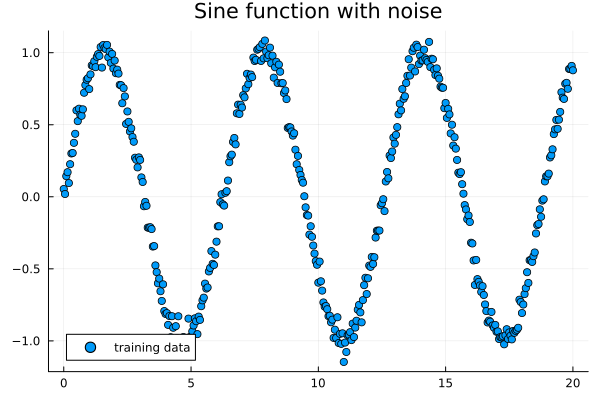

In [421]:
scatter(t_train, y_train, label="training data", title="Sine function with noise")

Creemos el modelo en el cual vamos a usar una red con una capa RNN otra capa LSTM y al final una capa densa

In [422]:
modelRNN = Chain(RNN(1 => 30, tanh), RNN(30 => 25, tanh), LSTM(25,10), GRU(10 => 5),
Dense(5 => 1, tanh));

Además creamos la función loss, esta será una suma de las funciones loss para cada secuencia.

In [423]:
function loss(x, y)
    sum(mse(modelRNN(xi), yi) for (xi, yi) in zip(x, y))
  end;

Ahora agrupemos los datos para ser entrenados en secuencias de 10

In [424]:
data = zip(t_train_data, y_train_data);
data_test = zip(t_test_data, y_test_data);

Guardamos los parámetros de la red y el método de optimización

In [425]:
ps = Flux.params(modelRNN)
opt= Adam(1e-3);

Hagamos los vectores de loss y de accuracy para cada época

In [426]:
lossRNN = []
lossRNN_test = []
accuracy_train = []
accuracy_test = []
function accuracy()
    num_correct = 0
    num_correct_test = 0

    # Transform into a flat Vector{Float32} the Vector{Vector{Float32}}
    flat_vector_train = reduce(vcat,reduce(vcat,t_train_data))
    flat_vector_test = reduce(vcat,reduce(vcat,t_test_data))
    flat_y_train = reduce(vcat,reduce(vcat,y_train_data))
    flat_y_test = reduce(vcat,reduce(vcat,y_test_data))

    for i in 1:length(flat_vector_train)
        if abs(modelRNN([flat_vector_train[i]])[1] - flat_y_train[i]) < 0.1
            num_correct += 1
        end
    end

    for i in 1:length(flat_vector_test)
        if abs(modelRNN([flat_vector_test[i]])[1] - flat_y_test[i]) < 0.1
            num_correct_test += 1
        end
    end

    return (num_correct/length(flat_vector_train)) * 100.0, (num_correct_test/length(flat_vector_test)) * 100.0
end

accuracy (generic function with 1 method)

Creamos la función callback y entrenamos durante 500 épocas. El entrenamiento puede tardar un poco aún así depende bastante de el tamaño de la secuencia. En este caso 10 está bien y entrena mas rápidamente que usando secuencias más cortas o mas largas

In [427]:
iter = 0
epoch_iter = 0
cb = function()
    global iter
    global epoch_iter
    iter += 1
    # Record Loss
    if iter % length(data) == 0
        epoch_iter += 1
        actual_loss = 0
        actual_loss_test = 0

        for (x, y) in data
            actual_loss += loss(x, y)
        end

        for (x, y) in data_test
            actual_loss_test += loss(x, y)
        end

        accuracytra, accuracytst = accuracy()

        if epoch_iter % 20 == 0
            println("Epoch $epoch_iter || Loss = $actual_loss")
        end
        push!(lossRNN, actual_loss)
        push!(lossRNN_test, actual_loss_test)
        push!(accuracy_train, accuracytra)
        push!(accuracy_test, accuracytst)
    end
end

for _ in 1:1000
    Flux.train!(loss, ps, data, opt, cb = cb)
end

Epoch 20 || Loss = 106.590645


Epoch 40 || Loss = 88.82669


Epoch 60 || Loss = 85.697784


Epoch 80 || Loss = 90.42676


Epoch 100 || Loss = 83.885826


Epoch 120 || Loss = 79.180405


Epoch 140 || Loss = 69.80055


Epoch 160 || Loss = 65.22979
Epoch 180 || Loss = 62.83557

Epoch 200 || Loss = 57.900402


Epoch 220 || Loss = 48.475925


Epoch 240 || Loss = 80.33991


Epoch 260 || Loss = 41.87291


Epoch 280 || Loss = 21.111221


Epoch 300 || Loss = 9.881153


Epoch 320 || Loss = 7.8468647
Epoch 340 || Loss = 6.570154

Epoch 360 || Loss = 5.236642


Epoch 380 || Loss = 4.985897
Epoch 400 || Loss = 4.5344915


Epoch 420 || Loss = 4.274276


Epoch 440 || Loss = 4.562618


Epoch 460 || Loss = 3.9543056


Epoch 480 || Loss = 3.626209


Epoch 500 || Loss = 4.2131863
Epoch 520 || Loss = 3.1096916


Epoch 540 || Loss = 5.308152


Epoch 560 || Loss = 2.7941008


Epoch 580 || Loss = 3.8395438


Epoch 600 || Loss = 2.777833


Epoch 620 || Loss = 4.1337323


Epoch 640 || Loss = 3.1254115


Epoch 660 || Loss = 3.2267494


Epoch 680 || Loss = 2.6781518


Epoch 700 || Loss = 3.578506


Epoch 720 || Loss = 2.6891167


Epoch 740 || Loss = 2.7967381


Epoch 760 || Loss = 2.9795783


Epoch 780 || Loss = 3.483837


Epoch 800 || Loss = 5.5441527


Epoch 820 || Loss = 5.198138


Epoch 840 || Loss = 2.7711864


Epoch 860 || Loss = 2.816699


Epoch 880 || Loss = 2.895996


Epoch 900 || Loss = 4.04182


Epoch 920 || Loss = 2.6338553


Epoch 940 || Loss = 4.1711383


Epoch 960 || Loss = 3.3001535


Epoch 980 || Loss = 3.194424
Epoch 1000 || Loss = 5.8689346


Epoch 1020 || Loss = 4.311218


Epoch 1040 || Loss = 4.3394003


Epoch 1060 || Loss = 4.243969


Epoch 1080 || Loss = 6.4322643


Epoch 1100 || Loss = 3.9099133


Epoch 1120 || Loss = 4.1987495


Epoch 1140 || Loss = 3.872258


Epoch 1160 || Loss = 4.9475


Epoch 1180 || Loss = 3.901468


Epoch 1200 || Loss = 5.863281


Epoch 1220 || Loss = 5.3299513


Epoch 1240 || Loss = 5.4078717


Epoch 1260 || Loss = 5.0507607


Epoch 1280 || Loss = 6.9276023


Epoch 1300 || Loss = 7.677685


Epoch 1320 || Loss = 6.497932


Epoch 1340 || Loss = 5.808395


Epoch 1360 || Loss = 5.883088


Epoch 1380 || Loss = 5.667022


Epoch 1400 || Loss = 7.3296075


Epoch 1420 || Loss = 7.6165247


Epoch 1440 || Loss = 6.112655


Epoch 1460 || Loss = 5.5782804


Epoch 1480 || Loss = 7.668567


Epoch 1500 || Loss = 8.629522

Epoch 1520 || Loss = 7.303928
Epoch 1540 || Loss = 5.526737


Epoch 1560 || Loss = 7.4126477

Epoch 1580 || Loss = 8.977062
Epoch 1600 || Loss = 5.915868


Epoch 1620 || Loss = 6.103429

Epoch 1640 || Loss = 8.904482
Epoch 1660 || Loss = 6.617768


Epoch 1680 || Loss = 4.9419284


Epoch 1700 || Loss = 6.5721283


Epoch 1720 || Loss = 9.735351


Epoch 1740 || Loss = 5.307834


Epoch 1760 || Loss = 5.4971914


Epoch 1780 || Loss = 8.496177


Epoch 1800 || Loss = 5.2376328


Epoch 1820 || Loss = 5.985262


Epoch 1840 || Loss = 6.503504


Epoch 1860 || Loss = 6.718673


Epoch 1880 || Loss = 5.2119575


Epoch 1900 || Loss = 8.572204


Epoch 1920 || Loss = 5.9845967


Epoch 1940 || Loss = 8.919248


Epoch 1960 || Loss = 5.938097


Epoch 1980 || Loss = 7.82399


In [428]:
function Plotall()
    pl = scatter([x[1] for x in t_train_data[1]], [x[1] for x in y_train_data[1]], label="Data",color = "red")
    scatter!([x[1] for x in t_test_data[1]], [x[1] for x in y_test_data[1]], label="Data",color = "purple")
    scatter!([x[1] for x in t_train_data[1]], [modelRNN(x)[1] for x in t_train_data[1]], label="Prediction",color = "blue")
    scatter!([x[1] for x in t_test_data[1]], [modelRNN(x)[1] for x in t_test_data[1]], label="Test Prediction",color = "orange")

    for i in 2:length(t_train_data)
        scatter!([x[1] for x in t_train_data[i]], [x[1] for x in y_train_data[i]],color = "red",label = false)
        scatter!([x[1] for x in t_test_data[i]], [x[1] for x in y_test_data[i]],color = "purple",label = false)
        scatter!([x[1] for x in t_train_data[i]], [modelRNN(x)[1] for x in t_train_data[i]],color = "blue",label = false)
        scatter!([x[1] for x in t_test_data[i]], [modelRNN(x)[1] for x in t_test_data[i]],color = "orange",label = false)
    end
    pl
end

Epoch 2000 || Loss = 5.622301


Plotall (generic function with 1 method)

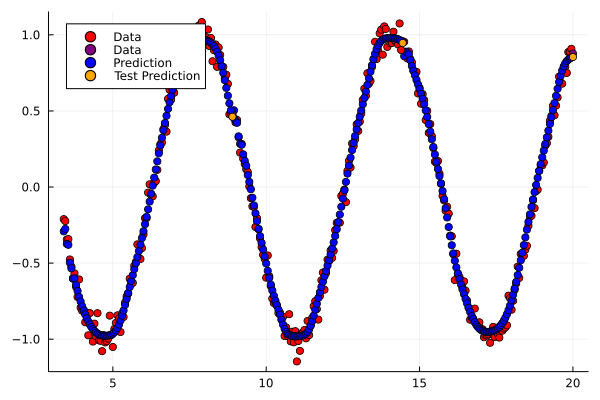

In [429]:
Plotall()

Si nos fijamos la red predice los valores bien en un rango, pero necesita mucho mas entrenamiento que una red convencional. Veamos ahora el loss a través de las épocas

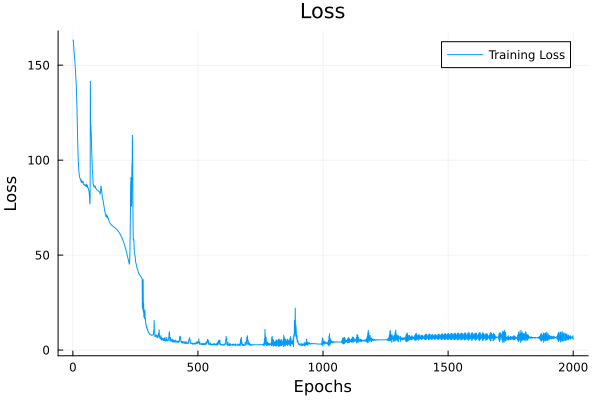

In [438]:
plot(lossRNN, label="Training Loss", title="Loss",xlabel = "Epochs", ylabel = "Loss")

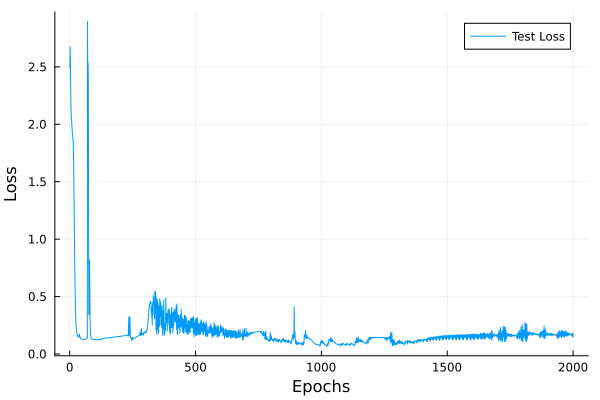

In [439]:
plot(lossRNN_test, label="Test Loss",xlabel="Epochs", ylabel = "Loss")

In [440]:
plot(accuracy_train, label="Training Accuracy", title="Accuracy",xlabel = "Epochs", ylabel = "Accuracy")
println("Maximum accuracy in training: ", maximum(accuracy_train))

Maximum accuracy in training: 95.15151515151516


In [441]:
plot(accuracy_test, label="Test Accuracy",xlabel = "Epochs", ylabel = "Accuracy") # Esto es un poco engañoso por que realmente son pocos puntos de testeo
println("Maximum accuracy in test: ", maximum(accuracy_test))

Maximum accuracy in test: 66.66666666666666
